In [2]:
import pandas as pd
import numpy as np
import missingno as msno

## Data Cleaning

In [3]:
df = pd.read_csv('C:/Users/19229/OneDrive/Desktop/data1030-fall2025/midterm presentation/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape
df.head()
df.dtypes
#df = df.drop(['customerID'], axis = 1), already done

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2265.000258
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1400.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


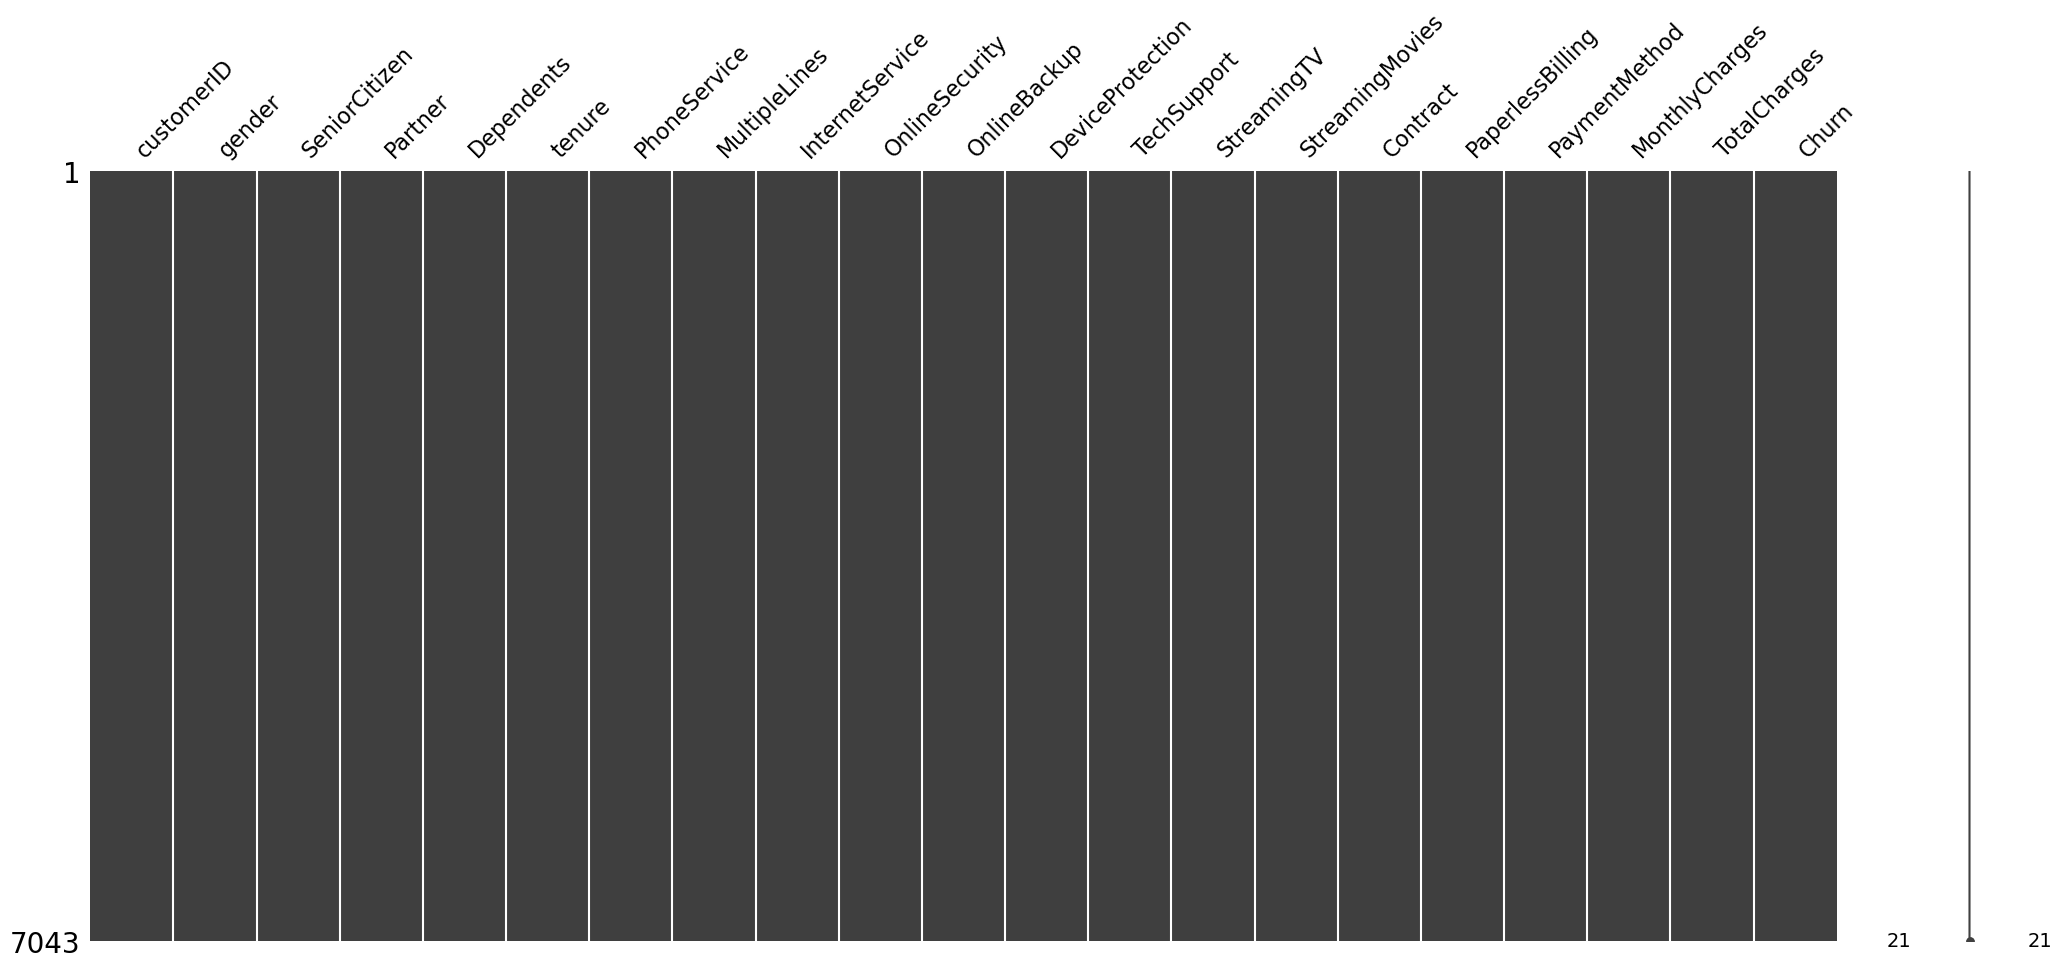

In [4]:
msno.matrix(df)
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
print(df.isnull().sum())
df[np.isnan(df['TotalCharges'])]
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())
print(df.isnull().sum())

df["SeniorCitizen"] = df["SeniorCitizen"].map({0:"No", 1:"Yes"}).astype("category") #change int to bool for onee-hot encoding
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

## EDA

In [5]:
import matplotlib.pyplot as plt
import os
plt.rcParams["figure.figsize"] = (7,4)

os.makedirs("reports/figures", exist_ok=True)

target = "Churn"

_churn_num = df[target].map({"No":0, "Yes":1})#temperory switch to 0/1 for matrix and EDA

In [6]:
print("Shape:", df.shape)
print("Missing per column after cleaning:\n", df.isna().sum()[df.isna().sum()>0])
print("Churn distribution:\n", df[target].value_counts())
print("Positive rate:", _churn_num.mean().round(3))
print("\nNumeric summary:\n", df[numerical_cols].describe().T)

Shape: (7043, 21)
Missing per column after cleaning:
 Series([], dtype: int64)
Churn distribution:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64
Positive rate: 0.265

Numeric summary:
                  count         mean          std    min      25%      50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.000    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.500    70.35   
TotalCharges    7043.0  2283.300441  2265.000258  18.80  402.225  1400.55   

                    75%      max  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80  


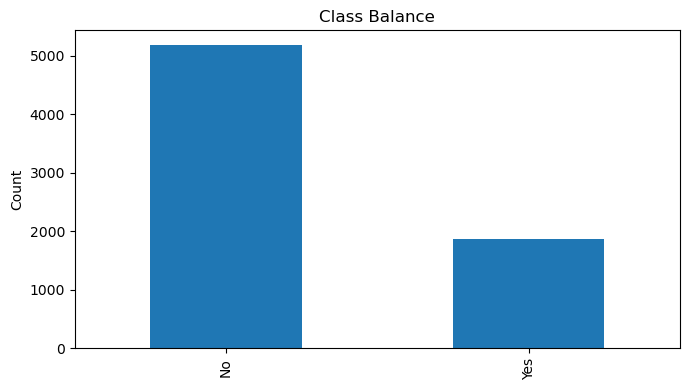

In [7]:
ax = df[target].value_counts().reindex(["No","Yes"]).plot(kind="bar")
ax.set_title("Class Balance");
ax.set_ylabel("Count"); 
ax.set_xlabel("")
plt.tight_layout();
plt.savefig("reports/figures/eda_class_balance.png", dpi=200); 
plt.show()

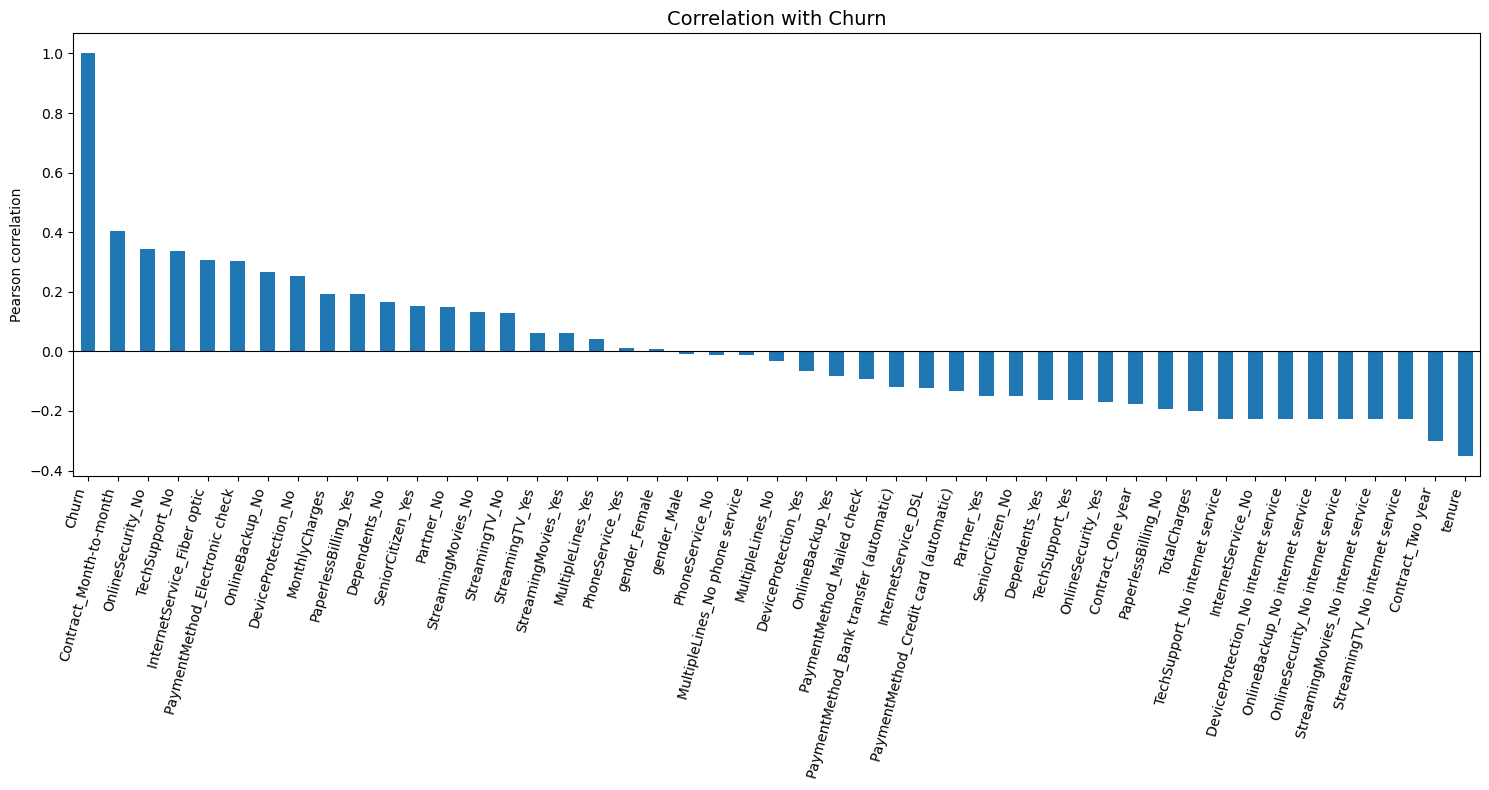

In [15]:
data = df.copy()
data["Churn"] = data["Churn"].map({"No":0, "Yes":1}).astype(int)
if "customerID" in data.columns:
    data = data.drop(columns=["customerID"])

dummies = pd.get_dummies(data, dtype=int)

y = dummies["Churn"]
X = dummies.drop(columns="Churn")
corr = X.corrwith(y)      

corr_with_target = pd.concat([pd.Series({"Churn": 1.0}), corr])

corr_sorted = corr_with_target.sort_values(ascending=False)

plt.figure(figsize=(15, 8))
corr_sorted.plot(kind="bar")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Correlation with Churn", fontsize=14)
plt.ylabel("Pearson correlation")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

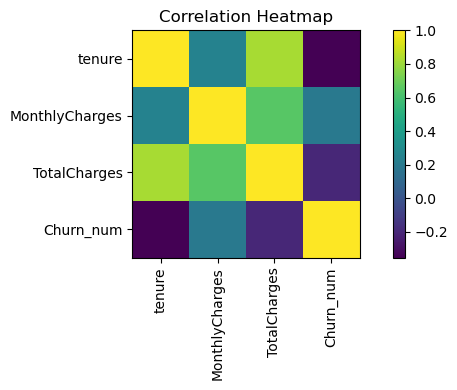

Top correlation with Churn_num:
 tenure            0.352229
TotalCharges      0.199428
MonthlyCharges    0.193356
Name: Churn_num, dtype: float64


In [8]:
corr_df = df[numerical_cols].copy()
corr_df["Churn_num"] = _churn_num
corr = corr_df.corr()

plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout(); plt.savefig("reports/figures/eda_corr_heatmap.png", dpi=200); 
plt.show()

print("Top correlation with Churn_num:\n", corr["Churn_num"].drop("Churn_num").abs().sort_values(ascending=False))

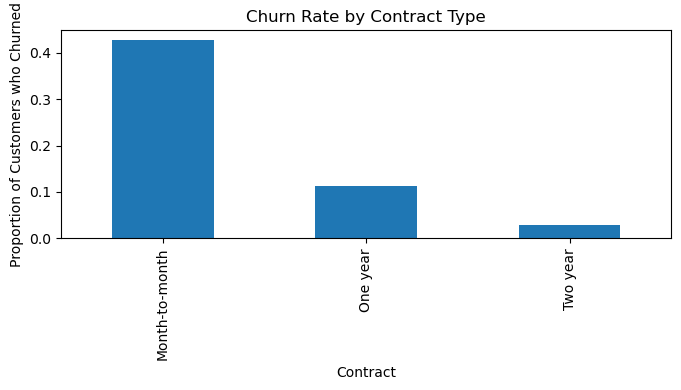

In [17]:
churn_by_contract = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()['Yes']
churn_by_contract.plot(kind='bar')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion of Customers who Churned')
plt.tight_layout(); 
plt.show()

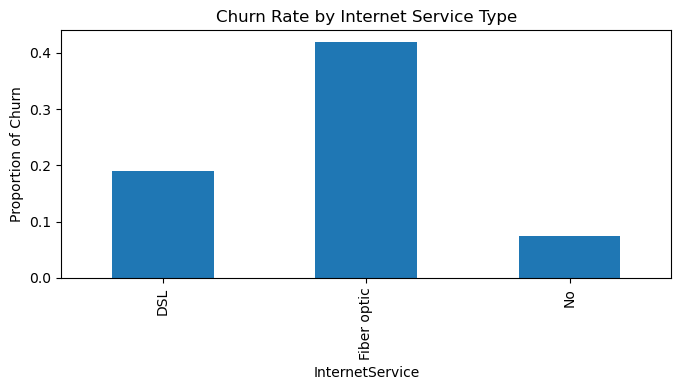

In [19]:
churn_by_service = df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()['Yes']
churn_by_service.plot(kind='bar')
plt.title('Churn Rate by Internet Service Type')
plt.ylabel('Proportion of Churn')
plt.tight_layout(); plt.show()


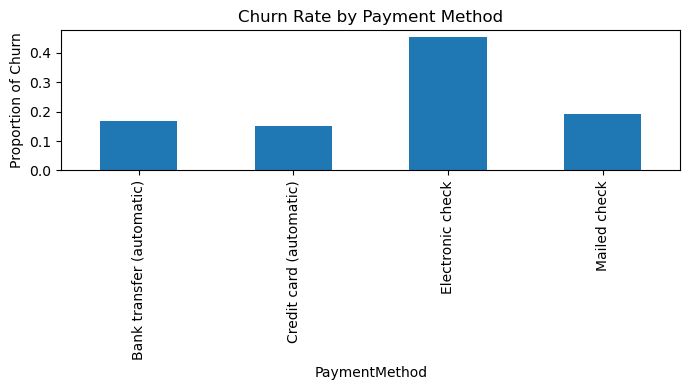

In [21]:
churn_by_payment = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack()['Yes']
churn_by_payment.plot(kind='bar')
plt.title('Churn Rate by Payment Method')
plt.ylabel('Proportion of Churn')
plt.tight_layout(); plt.show()

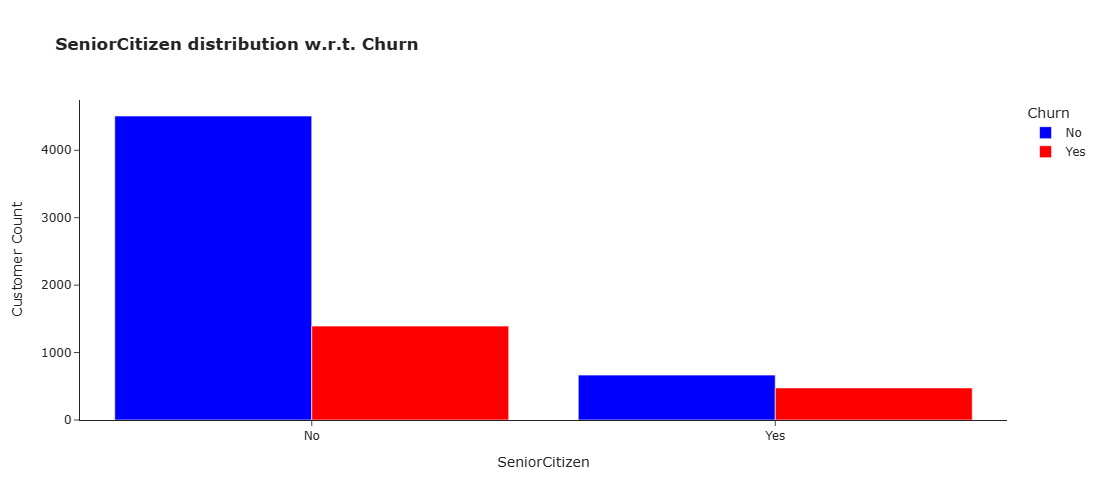

In [32]:
top_cat = "SeniorCitizen" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

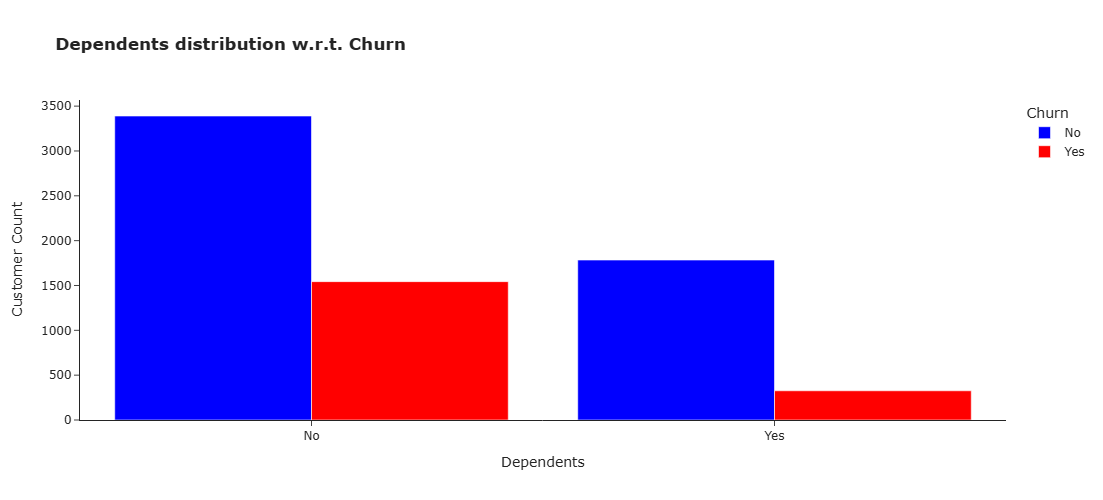

In [30]:
import plotly.express as px
top_cat = "Dependents" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

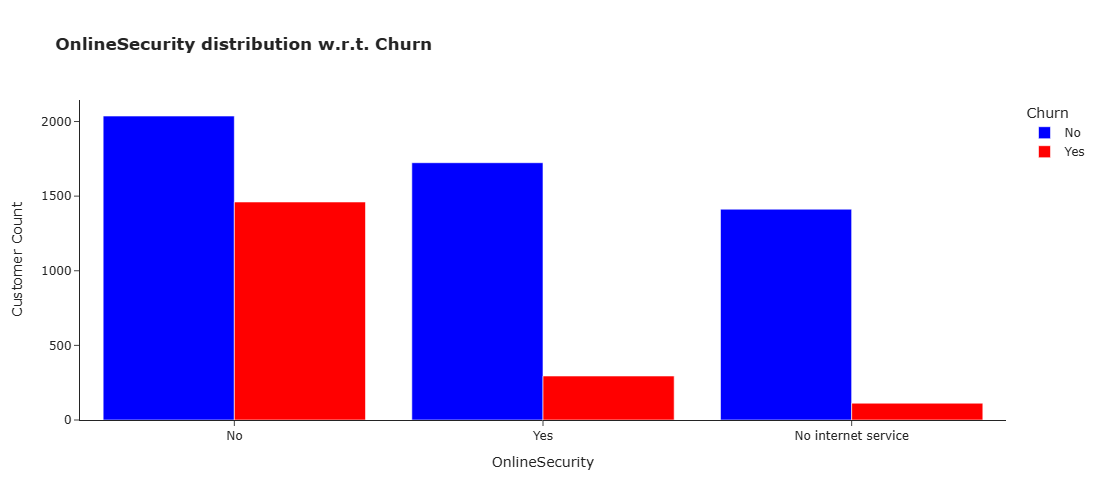

In [31]:
top_cat = "OnlineSecurity" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

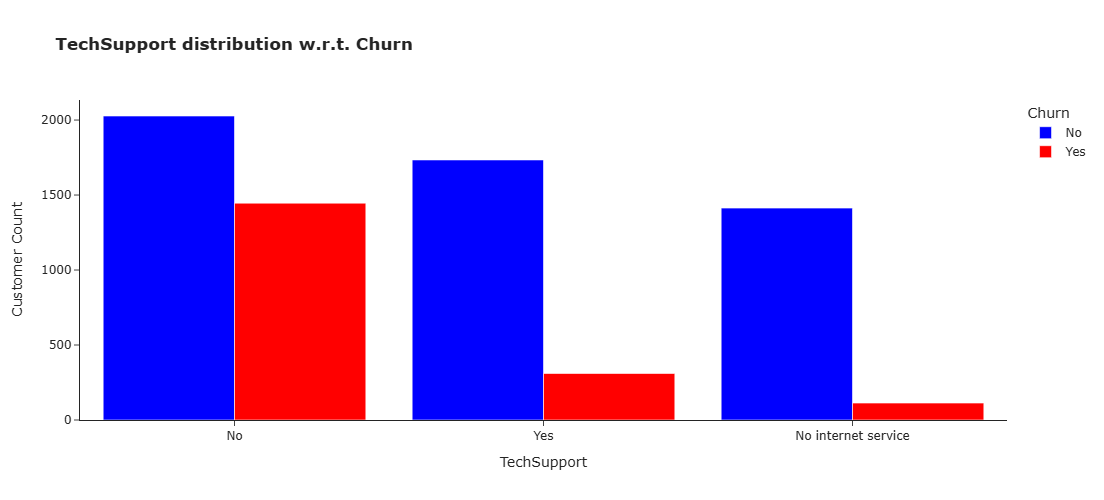

In [33]:
top_cat = "TechSupport" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

## Preprocessing

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

y = df["Churn"].map({"No": 0, "Yes": 1}).astype(int)
X = df.drop(columns=["Churn", "customerID"], errors="ignore")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Positive rate train/test: {y_train.mean():.3f}/{y_test.mean():.3f}")

Numeric cols: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical cols: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Train: (5634, 19), Test: (1409, 19)
Positive rate train/test: 0.265/0.265


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

In [37]:
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)

ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
ohe_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, ohe_names]
print("Total features after preprocessing:", len(feature_names))

Processed shapes: (5634, 46) (1409, 46)
Total features after preprocessing: 46
